In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_AR_v6 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v1 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-12 19:11:54.689931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:11:54.690331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:11:54.728731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:11:54.729094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:11:54.729300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_038'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_038
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

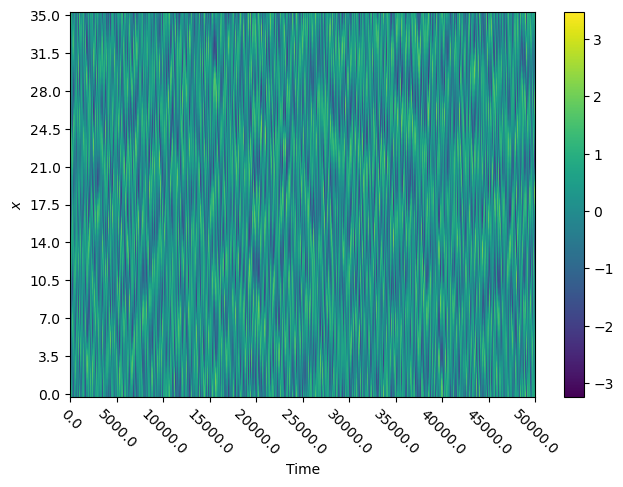

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 70])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0073 - mse: 4.9669e-04 - NMSE: 0.0045 - covmat_fro_loss: 2.6644e-04 - global_gradnorm: 0.4861 - tot_time: 0h 0m 26.6s

Epoch 1: val_NMSE improved from inf to 0.00448, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/check

Epoch 11/1000
76/76 [==============================] - ETA: 0s - loss: 0.0059 - mse: 3.5434e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2833e-04 - global_gradnorm: 0.3745 - tot_time: 0h 1m 52.8s

Epoch 11: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0059 - mse: 3.5434e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2860e-04 - global_gradnorm: 0.3751 - val_loss: 0.0061 - val_mse: 3.8421e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0059 - mse: 3.5577e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2856e-04 - global_gradnorm: 0.3736 - tot_time: 0h 2m 0.9s

Epoch 12: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0051 - mse: 2.9888e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1106e-04 - global_gradnorm: 0.3107 - tot_time: 0h 3m 34.9s

Epoch 23: val_NMSE did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0051 - mse: 2.9888e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1091e-04 - global_gradnorm: 0.3104 - val_loss: 0.0055 - val_mse: 3.4726e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
76/76 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.0092e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1188e-04 - global_gradnorm: 0.3154 - tot_time: 0h 3m 43.2s

Epoch 24: val_NMSE did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.7492e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0359e-04 - global_gradnorm: 0.2892 - tot_time: 0h 5m 17.2s

Epoch 35: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 113ms/step - loss: 0.0047 - mse: 2.7492e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0351e-04 - global_gradnorm: 0.2897 - val_loss: 0.0052 - val_mse: 3.2551e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
76/76 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.7530e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0349e-04 - global_gradnorm: 0.3015 - tot_time: 0h 5m 25.7s

Epoch 36: val_NMSE improved from 0.00283 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5677e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9713e-04 - global_gradnorm: 0.2720 - tot_time: 0h 6m 59.2s

Epoch 47: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0044 - mse: 2.5677e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9738e-04 - global_gradnorm: 0.2718 - val_loss: 0.0050 - val_mse: 3.2085e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5095e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9527e-04 - global_gradnorm: 0.2654 - tot_time: 0h 7m 7.6s

Epoch 48: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.3932e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9079e-04 - global_gradnorm: 0.2547 - tot_time: 0h 8m 40.4s

Epoch 59: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0042 - mse: 2.3932e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9089e-04 - global_gradnorm: 0.2549 - val_loss: 0.0045 - val_mse: 2.8044e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4744e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9412e-04 - global_gradnorm: 0.2743 - tot_time: 0h 8m 48.8s

Epoch 60: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3030e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8749e-04 - global_gradnorm: 0.2389 - tot_time: 0h 10m 22.0s

Epoch 71: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0040 - mse: 2.3030e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8776e-04 - global_gradnorm: 0.2401 - val_loss: 0.0045 - val_mse: 2.9319e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3070e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8803e-04 - global_gradnorm: 0.2386 - tot_time: 0h 10m 30.4s

Epoch 72: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.1404e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8121e-04 - global_gradnorm: 0.2227 - tot_time: 0h 12m 2.8s

Epoch 83: val_NMSE improved from 0.00229 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0038 - mse: 2.1404e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8111e-04 - global_gradnorm: 0.2222 - val_loss: 0.0041 - val_mse: 2.5397e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.1827e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8327e-04 - global_gradnorm: 0.2314 - tot_time: 0h 12m 11.3s

Epoch 84

Epoch 95/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.0649e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7854e-04 - global_gradnorm: 0.2117 - tot_time: 0h 13m 43.6s

Epoch 95: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0036 - mse: 2.0649e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7843e-04 - global_gradnorm: 0.2114 - val_loss: 0.0040 - val_mse: 2.4852e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.0920e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7963e-04 - global_gradnorm: 0.2170 - tot_time: 0h 13m 51.7s

Epoch 96: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.0103e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7644e-04 - global_gradnorm: 0.2131 - tot_time: 0h 15m 23.9s

Epoch 107: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0035 - mse: 2.0103e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7647e-04 - global_gradnorm: 0.2135 - val_loss: 0.0040 - val_mse: 2.5475e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.0894e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7956e-04 - global_gradnorm: 0.2222 - tot_time: 0h 15m 32.3s

Epoch 108: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.1371e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8134e-04 - global_gradnorm: 0.2321 - tot_time: 0h 17m 4.6s

Epoch 119: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0036 - mse: 2.1371e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8143e-04 - global_gradnorm: 0.2324 - val_loss: 0.0039 - val_mse: 2.4887e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 1.9014e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7175e-04 - global_gradnorm: 0.2088 - tot_time: 0h 17m 13.0s

Epoch 120: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 131/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 1.9447e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7371e-04 - global_gradnorm: 0.2052 - tot_time: 0h 18m 45.4s

Epoch 131: val_NMSE improved from 0.00210 to 0.00206, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0034 - mse: 1.9447e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7382e-04 - global_gradnorm: 0.2052 - val_loss: 0.0037 - val_mse: 2.2869e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 1.9370e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7335e-04 - global_gradnorm: 0.2054 - tot_time: 0h 18m 54.1s

Epoc

Epoch 143/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 1.9645e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7487e-04 - global_gradnorm: 0.2210 - tot_time: 0h 20m 26.5s

Epoch 143: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0034 - mse: 1.9645e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7485e-04 - global_gradnorm: 0.2212 - val_loss: 0.0038 - val_mse: 2.4773e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 1.9475e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7409e-04 - global_gradnorm: 0.2032 - tot_time: 0h 20m 34.9s

Epoch 144: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 155/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.8447e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6953e-04 - global_gradnorm: 0.1944 - tot_time: 0h 22m 7.3s

Epoch 155: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0032 - mse: 1.8447e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6958e-04 - global_gradnorm: 0.1942 - val_loss: 0.0036 - val_mse: 2.2449e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 156/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.8555e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6988e-04 - global_gradnorm: 0.2043 - tot_time: 0h 22m 15.7s

Epoch 156: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 167/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.8355e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6903e-04 - global_gradnorm: 0.1964 - tot_time: 0h 23m 48.0s

Epoch 167: val_NMSE did not improve from 0.00195
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0032 - mse: 1.8355e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6924e-04 - global_gradnorm: 0.1974 - val_loss: 0.0036 - val_mse: 2.2843e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 168/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.8280e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6863e-04 - global_gradnorm: 0.1981 - tot_time: 0h 23m 56.4s

Epoch 168: val_NMSE did not improve from 0.00195
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 179/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.7800e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6676e-04 - global_gradnorm: 0.1846 - tot_time: 0h 25m 28.0s

Epoch 179: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0031 - mse: 1.7800e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6682e-04 - global_gradnorm: 0.1848 - val_loss: 0.0035 - val_mse: 2.2923e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 180/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.7825e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6671e-04 - global_gradnorm: 0.1819 - tot_time: 0h 25m 36.3s

Epoch 180: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 191/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.7714e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6653e-04 - global_gradnorm: 0.1840 - tot_time: 0h 27m 8.8s

Epoch 191: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0031 - mse: 1.7714e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6669e-04 - global_gradnorm: 0.1845 - val_loss: 0.0034 - val_mse: 2.2030e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 192/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.7257e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6433e-04 - global_gradnorm: 0.1741 - tot_time: 0h 27m 17.1s

Epoch 192: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.7350e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6456e-04 - global_gradnorm: 0.1900 - tot_time: 0h 28m 49.1s

Epoch 203: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0030 - mse: 1.7350e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6442e-04 - global_gradnorm: 0.1900 - val_loss: 0.0034 - val_mse: 2.2289e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 204/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.7386e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6464e-04 - global_gradnorm: 0.1830 - tot_time: 0h 28m 57.6s

Epoch 204: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.6991e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6318e-04 - global_gradnorm: 0.1843 - tot_time: 0h 30m 29.2s

Epoch 215: val_NMSE improved from 0.00186 to 0.00184, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0030 - mse: 1.6991e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6327e-04 - global_gradnorm: 0.1842 - val_loss: 0.0032 - val_mse: 2.0411e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 216/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.6608e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6127e-04 - global_gradnorm: 0.1746 - tot_time: 0h 30m 37.7s

Epoch 216: val_NMSE

Epoch 227/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.6316e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5988e-04 - global_gradnorm: 0.1675 - tot_time: 0h 32m 9.7s

Epoch 227: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0029 - mse: 1.6316e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5995e-04 - global_gradnorm: 0.1677 - val_loss: 0.0033 - val_mse: 2.1029e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 228/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.6677e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6188e-04 - global_gradnorm: 0.1759 - tot_time: 0h 32m 18.0s

Epoch 228: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.6351e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6033e-04 - global_gradnorm: 0.1757 - tot_time: 0h 33m 49.3s

Epoch 239: val_NMSE improved from 0.00180 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0028 - mse: 1.6351e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6019e-04 - global_gradnorm: 0.1754 - val_loss: 0.0031 - val_mse: 1.9540e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 240/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.6083e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5874e-04 - global_gradnorm: 0.1675 - tot_time: 0h 33m 57.7s

Epoch 240: val_NMSE

Epoch 251/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.5955e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5833e-04 - global_gradnorm: 0.1686 - tot_time: 0h 35m 28.8s

Epoch 251: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0028 - mse: 1.5955e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5838e-04 - global_gradnorm: 0.1686 - val_loss: 0.0032 - val_mse: 2.0305e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 252/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.6942e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6323e-04 - global_gradnorm: 0.1819 - tot_time: 0h 35m 37.2s

Epoch 252: val_NMSE improved from 0.00176 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 263/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5640e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5687e-04 - global_gradnorm: 0.1661 - tot_time: 0h 37m 9.0s

Epoch 263: val_NMSE improved from 0.00169 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0027 - mse: 1.5640e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5678e-04 - global_gradnorm: 0.1658 - val_loss: 0.0030 - val_mse: 1.8594e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 264/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.6235e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5974e-04 - global_gradnorm: 0.1719 - tot_time: 0h 37m 17.5s

Epoch

Epoch 275/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5659e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5706e-04 - global_gradnorm: 0.1620 - tot_time: 0h 38m 49.7s

Epoch 275: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0027 - mse: 1.5659e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5714e-04 - global_gradnorm: 0.1618 - val_loss: 0.0031 - val_mse: 1.9796e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 276/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5641e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5689e-04 - global_gradnorm: 0.1644 - tot_time: 0h 38m 58.2s

Epoch 276: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5594e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5676e-04 - global_gradnorm: 0.1603 - tot_time: 0h 40m 30.4s

Epoch 287: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0027 - mse: 1.5594e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5680e-04 - global_gradnorm: 0.1605 - val_loss: 0.0031 - val_mse: 2.0653e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 288/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5698e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5740e-04 - global_gradnorm: 0.1630 - tot_time: 0h 40m 38.8s

Epoch 288: val_NMSE improved from 0.00167 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/chec

Epoch 299/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5332e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5561e-04 - global_gradnorm: 0.1619 - tot_time: 0h 42m 11.5s

Epoch 299: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0027 - mse: 1.5332e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5559e-04 - global_gradnorm: 0.1618 - val_loss: 0.0030 - val_mse: 1.8828e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 300/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5147e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5448e-04 - global_gradnorm: 0.1506 - tot_time: 0h 42m 19.8s

Epoch 300: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 311/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.6262e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6004e-04 - global_gradnorm: 0.1754 - tot_time: 0h 43m 53.3s

Epoch 311: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 112ms/step - loss: 0.0027 - mse: 1.6262e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5989e-04 - global_gradnorm: 0.1750 - val_loss: 0.0030 - val_mse: 1.8889e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 312/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5626e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5698e-04 - global_gradnorm: 0.1716 - tot_time: 0h 44m 1.7s

Epoch 312: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5795e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5791e-04 - global_gradnorm: 0.1735 - tot_time: 0h 45m 34.6s

Epoch 323: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0027 - mse: 1.5795e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5799e-04 - global_gradnorm: 0.1733 - val_loss: 0.0030 - val_mse: 1.9664e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 324/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5699e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5733e-04 - global_gradnorm: 0.1660 - tot_time: 0h 45m 42.9s

Epoch 324: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

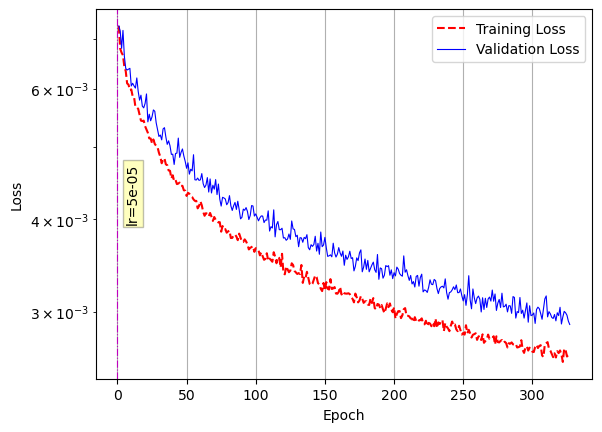

<Figure size 640x480 with 0 Axes>

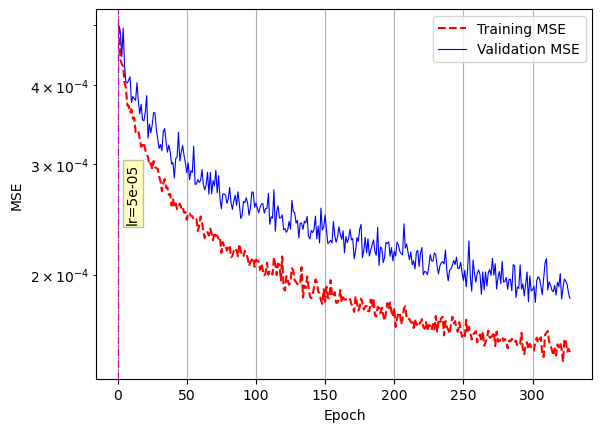

<Figure size 640x480 with 0 Axes>

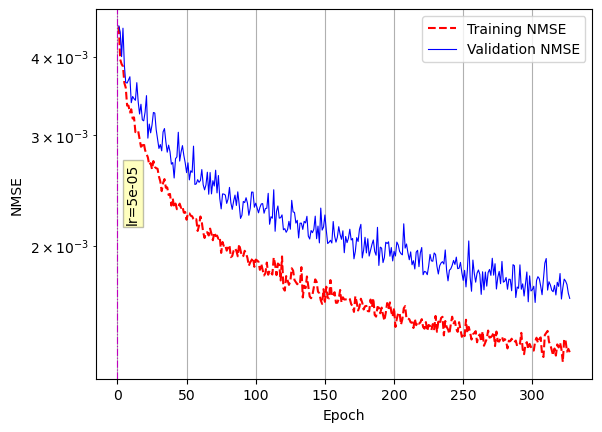

<Figure size 640x480 with 0 Axes>

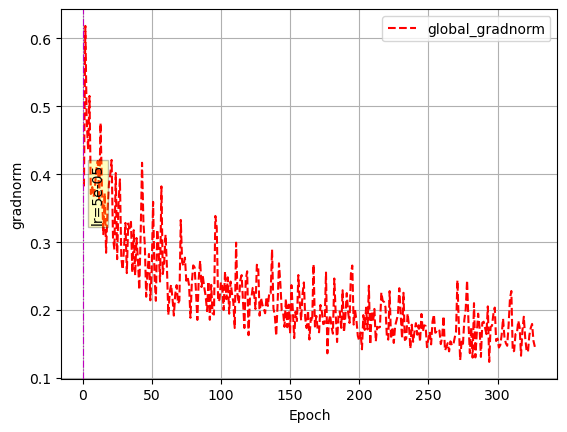



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.4947011470794678


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.3807e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.6020e-04 - global_gradnorm: 0.4460 - tot_time: 0h 0m 38.6s

Epoch 1: val_NMSE improved from inf to 0.00314, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.5386e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1801e-04 - global_gradnorm: 0.4209 - tot_time: 0h 2m 25.2s

Epoch 12: val_NMSE did not improve from 0.00310
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 134ms/step - loss: 0.0042 - mse: 3.5386e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1812e-04 - global_gradnorm: 0.4208 - val_loss: 0.0044 - val_mse: 3.7564e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.3727e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0840e-04 - global_gradnorm: 0.4043 - tot_time: 0h 2m 34.7s

Epoch 13: val_NMSE did not improve from 0.00310
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.9861e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8601e-04 - global_gradnorm: 0.3503 - tot_time: 0h 4m 21.3s

Epoch 24: val_NMSE improved from 0.00297 to 0.00292, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 142ms/step - loss: 0.0038 - mse: 2.9861e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8622e-04 - global_gradnorm: 0.3499 - val_loss: 0.0040 - val_mse: 3.2390e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.9461e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8321e-04 - global_gradnorm: 0.3642 - tot_time: 0h 4m 31.2s

Epoch 

Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.9233e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.8218e-04 - global_gradnorm: 0.3611 - tot_time: 0h 6m 17.9s

Epoch 36: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 136ms/step - loss: 0.0037 - mse: 2.9233e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.8241e-04 - global_gradnorm: 0.3610 - val_loss: 0.0040 - val_mse: 3.2673e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.7724e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7163e-04 - global_gradnorm: 0.3350 - tot_time: 0h 6m 27.4s

Epoch 37: val_NMSE improved from 0.00285 to 0.00269, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.7605e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7134e-04 - global_gradnorm: 0.3469 - tot_time: 0h 8m 15.2s

Epoch 48: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 140ms/step - loss: 0.0036 - mse: 2.7605e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7177e-04 - global_gradnorm: 0.3466 - val_loss: 0.0039 - val_mse: 3.2036e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.9126e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.8200e-04 - global_gradnorm: 0.3481 - tot_time: 0h 8m 25.0s

Epoch 49: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6900e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6845e-04 - global_gradnorm: 0.3286 - tot_time: 0h 10m 11.2s

Epoch 60: val_NMSE improved from 0.00269 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 136ms/step - loss: 0.0035 - mse: 2.6900e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6837e-04 - global_gradnorm: 0.3274 - val_loss: 0.0037 - val_mse: 2.9221e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.7353e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7099e-04 - global_gradnorm: 0.3491 - tot_time: 0h 10m 21.4s

Epoch 61: val_NMSE

Epoch 72/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6680e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6631e-04 - global_gradnorm: 0.3111 - tot_time: 0h 12m 8.1s

Epoch 72: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 136ms/step - loss: 0.0035 - mse: 2.6680e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6626e-04 - global_gradnorm: 0.3119 - val_loss: 0.0037 - val_mse: 2.8708e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6110e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.6297e-04 - global_gradnorm: 0.3208 - tot_time: 0h 12m 17.8s

Epoch 73: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 84/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6725e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6724e-04 - global_gradnorm: 0.3353 - tot_time: 0h 14m 3.7s

Epoch 84: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 137ms/step - loss: 0.0035 - mse: 2.6725e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6728e-04 - global_gradnorm: 0.3352 - val_loss: 0.0038 - val_mse: 2.9957e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.5745e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.6009e-04 - global_gradnorm: 0.2981 - tot_time: 0h 14m 13.3s

Epoch 85: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.5312e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5779e-04 - global_gradnorm: 0.3189 - tot_time: 0h 15m 59.2s

Epoch 96: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 136ms/step - loss: 0.0034 - mse: 2.5312e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5800e-04 - global_gradnorm: 0.3185 - val_loss: 0.0038 - val_mse: 2.9681e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 97/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.5090e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5619e-04 - global_gradnorm: 0.3127 - tot_time: 0h 16m 8.8s

Epoch 97: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028

<Figure size 640x480 with 0 Axes>

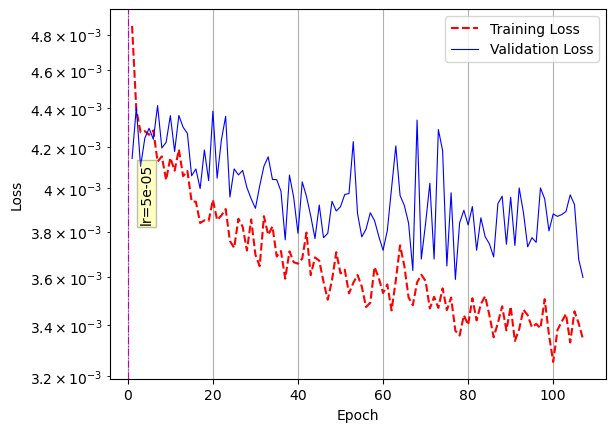

<Figure size 640x480 with 0 Axes>

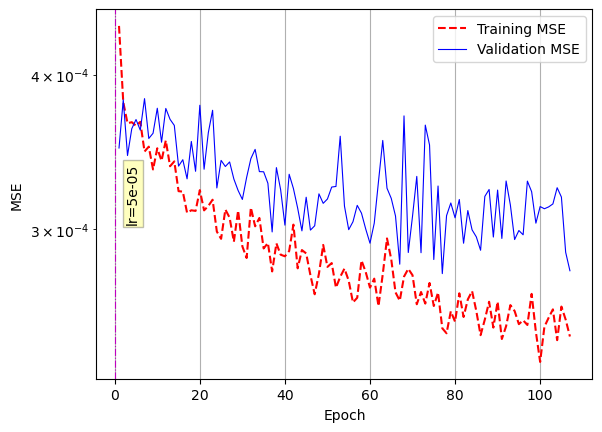

<Figure size 640x480 with 0 Axes>

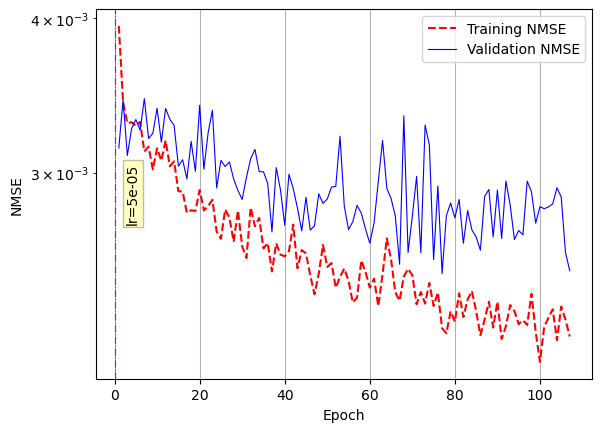

<Figure size 640x480 with 0 Axes>

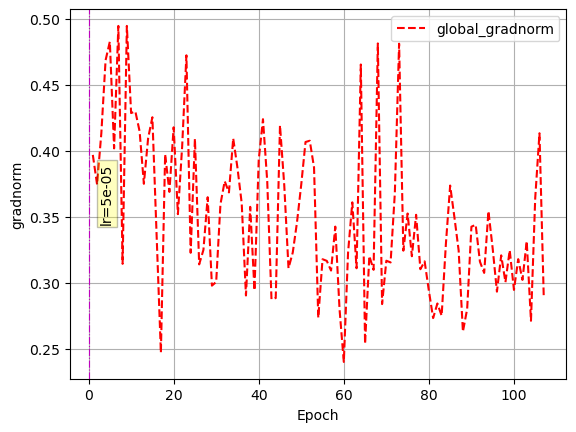



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.3957608938217163


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.3958 - tot_time: 0h 1m 45.9s

Epoch 1: val_NMSE improved from inf to 0.00885, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 8.4374e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.3958 - tot_time: 0h 4m 33.9s

Epoch 12: val_NMSE did not improve from 0.00835
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 259ms/step - loss: 0.0064 - mse: 8.4374e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.3958 - val_loss: 0.0072 - val_mse: 9.8543e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 8.1784e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 4m 48.8s

Epoch 13: val_NMSE did not improve from 0.00835
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

Epoch 24/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.6822e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 7m 35.1s

Epoch 24: val_NMSE did not improve from 0.00808
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 260ms/step - loss: 0.0060 - mse: 7.6822e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - val_loss: 0.0070 - val_mse: 9.4264e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 7.6038e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 7m 50.4s

Epoch 25: val_NMSE did not improve from 0.00808
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 7.2605e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 10m 36.4s

Epoch 36: val_NMSE did not improve from 0.00806
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 258ms/step - loss: 0.0057 - mse: 7.2605e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - val_loss: 0.0068 - val_mse: 9.1489e-04 - val_NMSE: 0.0082 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 7.3050e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 10m 51.3s

Epoch 37: val_NMSE did not improve from 0.00806
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoint

58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 7.0499e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 13m 36.0s

Epoch 48: val_NMSE did not improve from 0.00785
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 258ms/step - loss: 0.0056 - mse: 7.0499e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - val_loss: 0.0067 - val_mse: 8.8611e-04 - val_NMSE: 0.0080 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 6.9828e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.3958 - tot_time: 0h 13m 50.9s

Epoch 49: val_NMSE did not improve from 0.00785
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 267ms/step - loss: 0.0055 - mse: 6.7543e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - val_loss: 0.0065 - val_mse: 8.5242e-04 - val_NMSE: 0.0077 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.7271e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - tot_time: 0h 16m 53.8s

Epoch 61: val_NMSE did not improve from 0.00767
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 260ms/step - loss: 0.0054 - mse: 6.7271e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - val_loss: 0.0067 - val_mse:

Epoch 73/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 6.4660e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - tot_time: 0h 19m 57.8s

Epoch 73: val_NMSE did not improve from 0.00767
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 261ms/step - loss: 0.0053 - mse: 6.4660e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - val_loss: 0.0066 - val_mse: 8.8102e-04 - val_NMSE: 0.0079 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 74/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 6.5318e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - tot_time: 0h 20m 13.0s

Epoch 74: val_NMSE did not improve from 0.00767
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 261ms/step - loss: 0.0051 - mse: 6.1947e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - val_loss: 0.0067 - val_mse: 8.9543e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 86/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 6.3493e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - tot_time: 0h 23m 15.7s

Epoch 86: val_NMSE did not improve from 0.00767
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 264ms/step - loss: 0.0052 - mse: 6.3493e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.3958 - val_loss: 0.0068 - val_mse:

<Figure size 640x480 with 0 Axes>

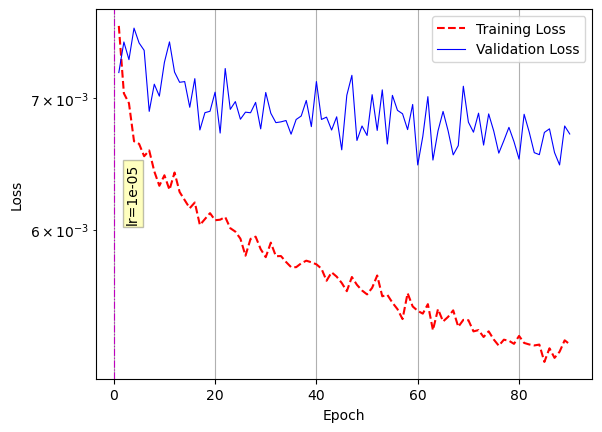

<Figure size 640x480 with 0 Axes>

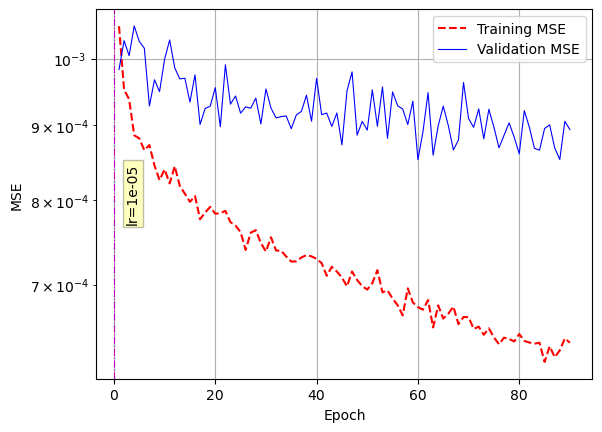

<Figure size 640x480 with 0 Axes>

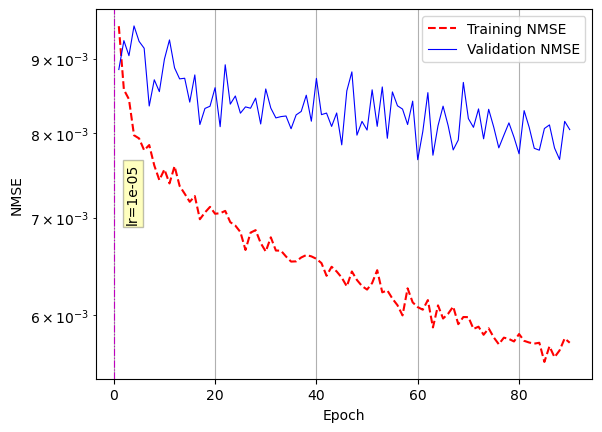

<Figure size 640x480 with 0 Axes>

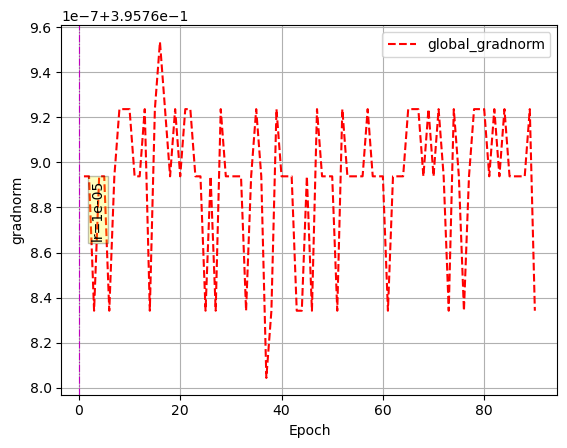



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.3166087627410889


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0106 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.3166 - tot_time: 0h 3m 13.8s

Epoch 1: val_NMSE improved from inf to 0.02164, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

49/49 [==============================] - ETA: 0s - loss: 0.0095 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.3166 - tot_time: 0h 6m 56.8s

Epoch 12: val_NMSE did not improve from 0.02128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 416ms/step - loss: 0.0095 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.3166 - val_loss: 0.0118 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
49/49 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 7m 17.0s

Epoch 13: val_NMSE did not improve from 0.02128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesChe

Epoch 24/1000
49/49 [==============================] - ETA: 0s - loss: 0.0091 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 10m 59.3s

Epoch 24: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 410ms/step - loss: 0.0091 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0116 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
49/49 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 11m 19.1s

Epoch 25: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/

Epoch 37/1000
49/49 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 15m 21.2s

Epoch 37: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 415ms/step - loss: 0.0088 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 38/1000
49/49 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 15m 41.2s

Epoch 38: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/

Epoch 50/1000
49/49 [==============================] - ETA: 0s - loss: 0.0086 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 19m 45.7s

Epoch 50: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 415ms/step - loss: 0.0086 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 51/1000
49/49 [==============================] - ETA: 0s - loss: 0.0086 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 20m 6.1s

Epoch 51: val_NMSE did not improve from 0.02041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/L

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 412ms/step - loss: 0.0085 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 63/1000
49/49 [==============================] - ETA: 0s - loss: 0.0085 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 24m 10.1s

Epoch 63: val_NMSE did not improve from 0.02034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 411ms/step - loss: 0.0085 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0116 - val_mse: 0.0023 - val_NM

Epoch 75/1000
49/49 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 28m 14.4s

Epoch 75: val_NMSE did not improve from 0.02034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 417ms/step - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - val_loss: 0.0117 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 76/1000
49/49 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3166 - tot_time: 0h 28m 34.6s

Epoch 76: val_NMSE did not improve from 0.02034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 410ms/step - loss: 0.0081 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 88/1000
49/49 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 32m 38.7s

Epoch 88: val_NMSE did not improve from 0.02032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 414ms/step - loss: 0.0082 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0117 - val_mse: 0.0024 - val_NM

Epoch 100/1000
49/49 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 36m 42.9s

Epoch 100: val_NMSE did not improve from 0.02032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 412ms/step - loss: 0.0080 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 101/1000
49/49 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 37m 3.5s

Epoch 101: val_NMSE did not improve from 0.02032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoin

Epoch 113/1000
49/49 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 41m 5.4s

Epoch 113: val_NMSE did not improve from 0.02032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 411ms/step - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 114/1000
49/49 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 41m 25.3s

Epoch 114: val_NMSE did not improve from 0.02032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 414ms/step - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0116 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 126/1000
49/49 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 45m 25.3s

Epoch 126: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 414ms/step - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0114 - val_mse: 0.0023 - val_

Epoch 138/1000
49/49 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 49m 28.1s

Epoch 138: val_NMSE improved from 0.02030 to 0.02020, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 21s 422ms/step - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0112 - val_mse: 0.0022 - val_NMSE: 0.0202 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 139/1000
49/49 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 49m 48.3s

Epoch 139: val_NMSE did not i

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 21s 420ms/step - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0113 - val_mse: 0.0023 - val_NMSE: 0.0204 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 151/1000
49/49 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 53m 51.0s

Epoch 151: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 411ms/step - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0113 - val_mse: 0.0023 - val_

Epoch 163/1000
49/49 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0125 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 57m 53.4s

Epoch 163: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 418ms/step - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0125 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0112 - val_mse: 0.0023 - val_NMSE: 0.0203 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 164/1000
49/49 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0014 - NMSE: 0.0125 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 0h 58m 13.6s

Epoch 164: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoi

Epoch 176/1000
49/49 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 1h 2m 16.2s

Epoch 176: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 408ms/step - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 177/1000
49/49 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.3166 - tot_time: 1h 2m 36.5s

Epoch 177: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoint

Epoch 188: early stopping


<Figure size 640x480 with 0 Axes>

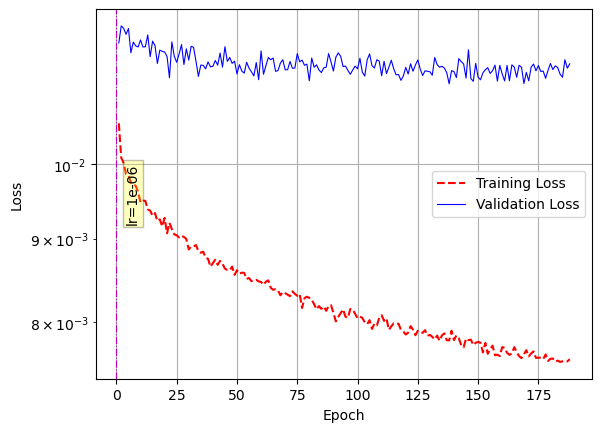

<Figure size 640x480 with 0 Axes>

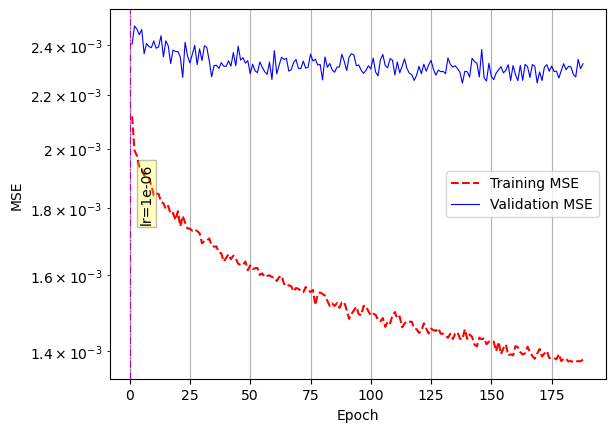

<Figure size 640x480 with 0 Axes>

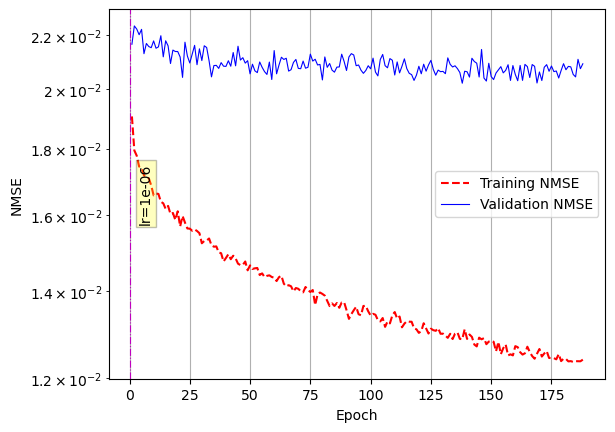

<Figure size 640x480 with 0 Axes>

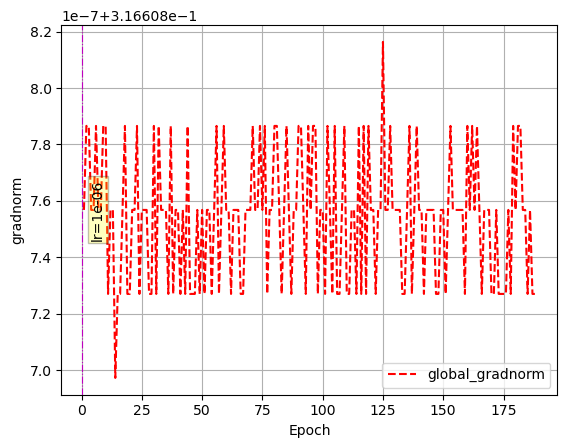



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 70 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.25328705310821537


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
42/42 [==============================] - ETA: 0s - loss: 0.0166 - mse: 0.0049 - NMSE: 0.0439 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.2533 - tot_time: 0h 4m 31.4s

Epoch 1: val_NMSE improved from inf to 0.04828, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 11/1000
42/42 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 8m 55.1s

Epoch 11: val_NMSE did not improve from 0.04698
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 635ms/step - loss: 0.0148 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.2533 - val_loss: 0.0178 - val_mse: 0.0052 - val_NMSE: 0.0472 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
42/42 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 9m 21.0s

Epoch 12: val_NMSE improved from 0.04698 to 0.04687, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/checkpoin

42/42 [==============================] - ETA: 0s - loss: 0.0143 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 14m 10.6s

Epoch 23: val_NMSE did not improve from 0.04677
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 630ms/step - loss: 0.0143 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - val_loss: 0.0177 - val_mse: 0.0052 - val_NMSE: 0.0469 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
42/42 [==============================] - ETA: 0s - loss: 0.0144 - mse: 0.0041 - NMSE: 0.0367 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 14m 36.3s

Epoch 24: val_NMSE did not improve from 0.04677
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesC

42/42 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0039 - NMSE: 0.0347 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 19m 25.0s

Epoch 35: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 626ms/step - loss: 0.0137 - mse: 0.0039 - NMSE: 0.0347 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - val_loss: 0.0180 - val_mse: 0.0053 - val_NMSE: 0.0478 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
42/42 [==============================] - ETA: 0s - loss: 0.0138 - mse: 0.0039 - NMSE: 0.0350 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 19m 51.7s

Epoch 36: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesC

Epoch 48/1000
42/42 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 25m 5.5s

Epoch 48: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 616ms/step - loss: 0.0136 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - val_loss: 0.0178 - val_mse: 0.0053 - val_NMSE: 0.0473 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
42/42 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0038 - NMSE: 0.0340 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 25m 31.8s

Epoch 49: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/L

Epoch 61/1000
42/42 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.2533 - tot_time: 0h 30m 40.5s

Epoch 61: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 612ms/step - loss: 0.0131 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.2533 - val_loss: 0.0176 - val_mse: 0.0052 - val_NMSE: 0.0464 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 62/1000
42/42 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0037 - NMSE: 0.0334 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.2533 - tot_time: 0h 31m 6.6s

Epoch 62: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/L

Epoch 74/1000
42/42 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0035 - NMSE: 0.0316 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.2533 - tot_time: 0h 36m 26.5s

Epoch 74: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 676ms/step - loss: 0.0127 - mse: 0.0035 - NMSE: 0.0316 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.2533 - val_loss: 0.0178 - val_mse: 0.0052 - val_NMSE: 0.0472 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 75/1000
42/42 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0036 - NMSE: 0.0321 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.2533 - tot_time: 0h 36m 54.2s

Epoch 75: val_NMSE did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_028/checkpoints/

<Figure size 640x480 with 0 Axes>

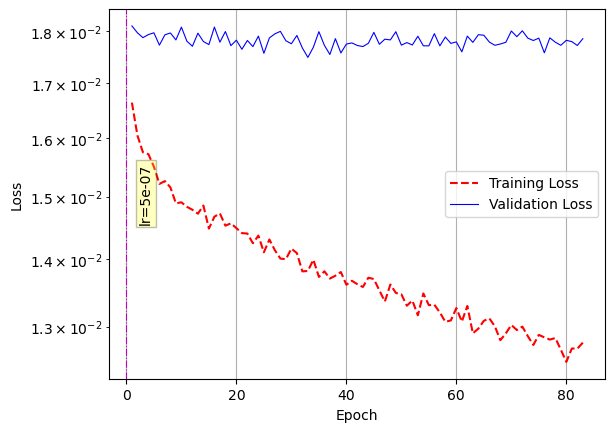

<Figure size 640x480 with 0 Axes>

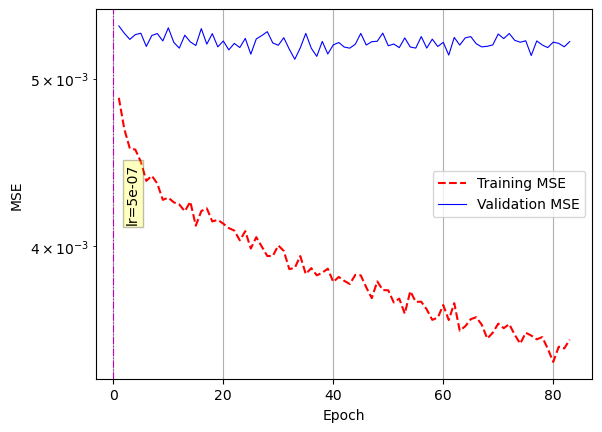

<Figure size 640x480 with 0 Axes>

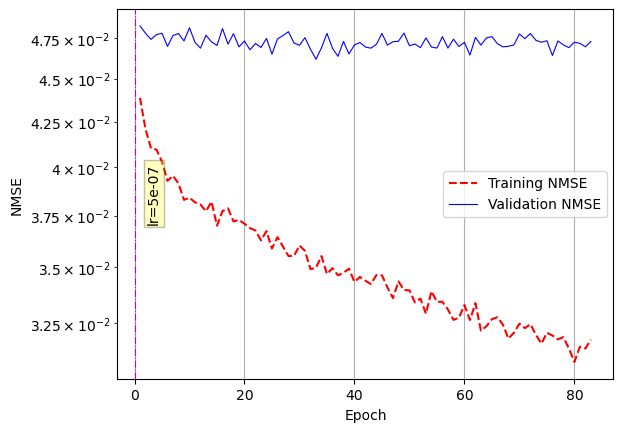

<Figure size 640x480 with 0 Axes>

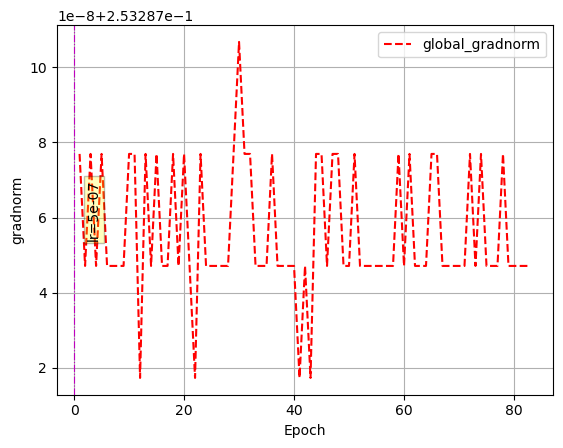

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.8
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [ ]:
a = 123e-5
a

In [ ]:
s = '{:E}'.format(a)
s

In [ ]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

In [ ]:
### Training the combined AE-RNN


# 